<p align="center">
  <img src="./img/ship.png" />
</p>

In [108]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load train dataset
df_train = pd.read_csv('./data/train.csv')

# Load test dataset
kaggle_data = pd.read_csv('./data/test.csv')
df_test = pd.read_csv('./data/test.csv')

# **3. Modeling**
This notebook follows steps to train a model to predict the survival of a passenger. These steps include:

1. **Filling missing data**: Preprocessing data is essential to ensure that the data the model is trained on is complete and clean. This step involves filling missing values in the dataset
2. **Normalizing features**: Normalizing columns to a fixed range to improve model performance
3. **Feature selection**: Selection of feature is important. Some columns in the data set are not important or relevant when predicting survival.
4. **Model training**: Training multiple models and comparing their performance is important for the model accuracy.
5. **Model Evaluation**: Evaluating the model with confusion matrices


## **3.1 Filling missing data**
As concluded in Notebook 0, some values for **Cabin, Embarked and Age** are missing. Because we will not be analysing or training the model for identifying columns, we do not need to fill the missing values for cabin. As the Embarked column is categorical, we will normalize the values using the One hot encoding technique so filling missing values will happen later (3.2)

In [109]:
# List all column information
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### **3.1.1 Age data**

For the missing age data (177 values) we can do two things:
- Fill data with the *mean* value of Age
- Fill missing data with the *median* of Age

As concluded in notebook 1, Age follows a normal distribution pattern. In that case the best fit for the missing data will be the *mean* of Age

**Embarked data**

--------------Age Data Information--------------
count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64


Text(0.5, 1.0, 'After Filling Missing Values')

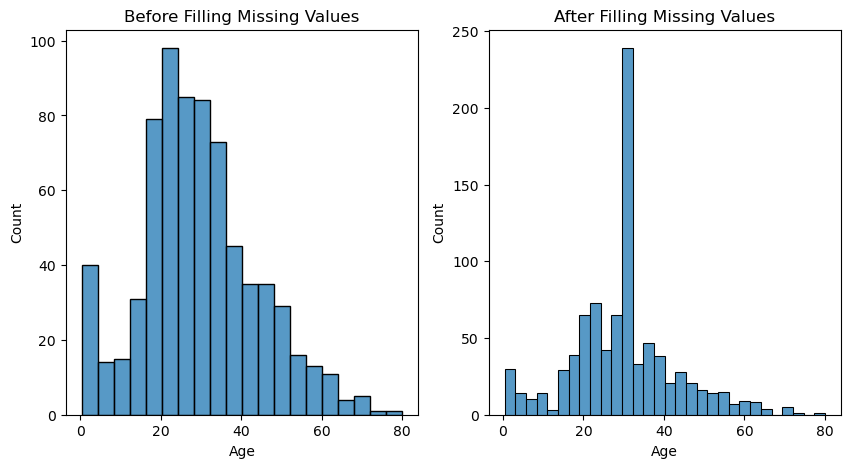

In [110]:
# Print age data information
print('--------------Age Data Information--------------')
print(df_train['Age'].describe())

# Plot histogram of Age column (with missing values)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(df_train['Age'], ax=ax[0])
ax[0].set_title('Before Filling Missing Values')

# Fill missing values in Age column with the mean value
df_train.fillna({'Age': df_train['Age'].mean()}, inplace=True)

# Plot histogram of Age column (after filling missing values)
sns.histplot(df_train['Age'], ax=ax[1])
ax[1].set_title('After Filling Missing Values')

### **3.1.2 Missing embarked data**
The departure data for 2 records seem to be missing. We will make sure every record has a Embark location. For missing values a new location (U = Unknown) will be introduced.

<Axes: xlabel='Embarked', ylabel='count'>

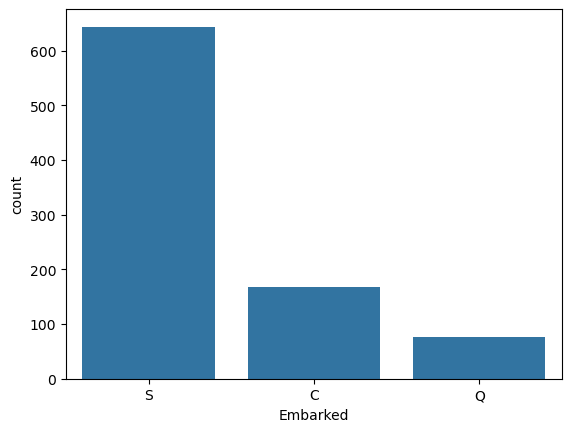

In [111]:
# Fill missing values in Embarked column with a new category 'U' for unknown
df_train.dropna(subset=['Embarked'], inplace=True)

# Plot histogram of Embarked column
sns.countplot(data=df_train, x='Embarked')

## **3.2 Normalizing features**
Some features needs to be standardized in order to be taken into the prediction calculation. Below is the dataframe as is now

In [112]:
print(df_train.info())
df_train.head()

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Name         889 non-null    object 
 4   Sex          889 non-null    object 
 5   Age          889 non-null    float64
 6   SibSp        889 non-null    int64  
 7   Parch        889 non-null    int64  
 8   Ticket       889 non-null    object 
 9   Fare         889 non-null    float64
 10  Cabin        202 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 90.3+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### **3.2.1 One-hot encoding**
Categorical fields are given a numerical value. This is done using the one-hot encoding technique. For each unique value, another column is added to the dataframe. (Figure 1)

![one hot encoding](./img/one-hot-encoding.png)
> Figure 1 (https://towardsdatascience.com/building-a-one-hot-encoding-layer-with-tensorflow-f907d686bf39)

For the titanic case, the following categorical values need to be converted to boolean columns

**Pclass**  
1 (Upper class)  
2 (Middle class)  
3 (Lower class)

**Sex**  
Male  
Female

**Embarked**  
S = Southampton  
C = Cherbourg  
Q = Queenstown  
U = Unknown (Added in 3.1)

In [113]:
# One-hot encode the embarked, sex and pclass columns
def one_hot_encode(df):
    return pd.get_dummies(df, columns=['Embarked', 'Sex', 'Pclass'])

df_train = one_hot_encode(df_train)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Name         889 non-null    object 
 3   Age          889 non-null    float64
 4   SibSp        889 non-null    int64  
 5   Parch        889 non-null    int64  
 6   Ticket       889 non-null    object 
 7   Fare         889 non-null    float64
 8   Cabin        202 non-null    object 
 9   Embarked_C   889 non-null    bool   
 10  Embarked_Q   889 non-null    bool   
 11  Embarked_S   889 non-null    bool   
 12  Sex_female   889 non-null    bool   
 13  Sex_male     889 non-null    bool   
 14  Pclass_1     889 non-null    bool   
 15  Pclass_2     889 non-null    bool   
 16  Pclass_3     889 non-null    bool   
dtypes: bool(8), float64(2), int64(4), object(3)
memory usage: 76.4+ KB


## **3.3 Feature selection**
From the previous analysis we have already concluded that the following columns can be dropped when training the model as they do not provide any useful data:

- **PassengerId**: Numerical identifier for the passenger, has nothing to do with survival.
- **Name**: Name of the survivor, has LITTLE to do with survival (exceptions of higher ranked citizens?)
- **Cabin**: Name/Number of the cabin. Data is often missing and doesnt nessecarely indicate location on the boat
- **Ticket** Number of the passenger ticket. has nothing to do with survival.

In [114]:
# Remove the PassengerId, Name, Ticket and Cabin columns
def remove_unused_columns(df):
    df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'], inplace=True)
    return df

df_train = remove_unused_columns(df_train)
df_train.head()

,Survived,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3
0,0,22.0,1,0,7.2500,False,False,True,False,True,False,False,True
1,1,38.0,1,0,71.2833,True,False,False,True,False,True,False,False
2,1,26.0,0,0,7.9250,False,False,True,True,False,False,False,True
3,1,35.0,1,0,53.1000,False,False,True,True,False,True,False,False
4,0,35.0,0,0,8.0500,False,False,True,False,True,False,False,True


In [115]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Split the data into X and y
y = df_train['Survived']
X = df_train.drop(columns='Survived')

# Split the data into training and validation sets (80% training, 20% validation) using x[0:train_size] and x[train_size:]
train_size = int(0.8 * len(X))
train_X = X[:train_size]
train_y = y[:train_size]
val_X = X[train_size:]
val_y = y[train_size:]


## **4.4 Model training**
Now that the data is ready for training a model, we need to make a descision on what model to use based on the performance on the data

### **4.3.1 Random Forest**
Random forest is a machine learning model which consists of a collection of Descision trees working together to make the best prediction possible. Each tree is trained on a random sample of data. When predicting survival each tree will calculate and predict on what the outcome is, and then the majority vote will decide what the outcome of the model will be (Figure 2)

![Random forest algorithm](./img/random-forest-algorithm.png)
- Figure 2 (https://williamkoehrsen.medium.com/random-forest-simple-explanation-377895a60d2d)

When training the random forest classifier it will ask for two hyperparameters. These parameters will be randomly tested on accuracy:
- n_estimators: The number of descision trees in the forest
- max_depth: The size of the tree (number of splits)

In [116]:
# Train a Random Forest model with different hyperparameters
best_accuracy = 0
best_forest_model = None

for estimator in [10, 50, 100, 500]:
    for depth in [1, 5, 10, 50]:
        model = RandomForestClassifier(n_estimators=estimator, max_depth=depth, random_state=1)
        model.fit(train_X, train_y)
        predictions = model.predict(val_X)
        accuracy = accuracy_score(val_y, predictions)

        print(f'Estimators: {estimator}, Depth: {depth}, Accuracy: {accuracy}')

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_forest_model = model


Estimators: 10, Depth: 1, Accuracy: 0.797752808988764
Estimators: 10, Depth: 5, Accuracy: 0.8539325842696629
Estimators: 10, Depth: 10, Accuracy: 0.8426966292134831
Estimators: 10, Depth: 50, Accuracy: 0.8089887640449438
Estimators: 50, Depth: 1, Accuracy: 0.797752808988764
Estimators: 50, Depth: 5, Accuracy: 0.8539325842696629
Estimators: 50, Depth: 10, Accuracy: 0.848314606741573
Estimators: 50, Depth: 50, Accuracy: 0.8202247191011236
Estimators: 100, Depth: 1, Accuracy: 0.797752808988764
Estimators: 100, Depth: 5, Accuracy: 0.848314606741573
Estimators: 100, Depth: 10, Accuracy: 0.8651685393258427
Estimators: 100, Depth: 50, Accuracy: 0.8258426966292135
Estimators: 500, Depth: 1, Accuracy: 0.797752808988764
Estimators: 500, Depth: 5, Accuracy: 0.848314606741573
Estimators: 500, Depth: 10, Accuracy: 0.8595505617977528
Estimators: 500, Depth: 50, Accuracy: 0.8258426966292135


## **3.5 Model evaluation**
Sometimes the models accuracy is not enough to validate the accuracy of the model. You can plot the accuracy in a confusion matrix and AUROC to validate whether the model is accurate or not

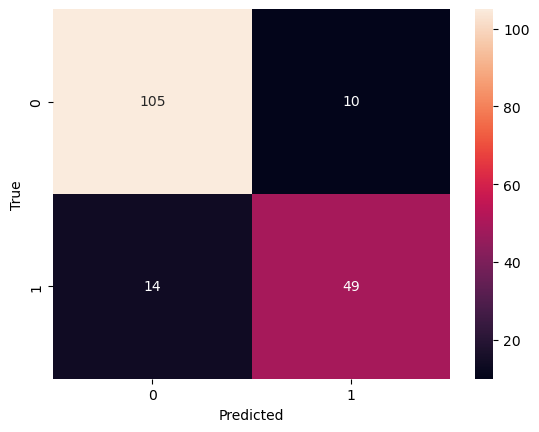

In [117]:
# Plot the confusion matrix of the validation predictions
conf_matrix = confusion_matrix(val_y, best_forest_model.predict(val_X))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

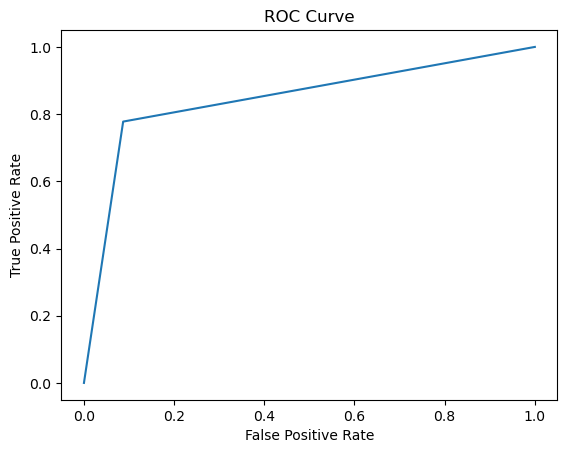

In [118]:
# Plot the ROC curve of the validation predictions
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(val_y, best_forest_model.predict(val_X))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

## **3.6 Save prediction**

In [119]:
# Load and clean the test data
df_test.fillna({'Embarked': 'U'}, inplace=True)

# Fill missing values in Age column with the mean value
df_test.fillna({'Age': df_test['Age'].mean()}, inplace=True)

# One-hot encode
df_test = one_hot_encode(df_test)

# Remove unused columns
df_test = remove_unused_columns(df_test)

# Make predictions and output to file
predictions_test = best_forest_model.predict(df_test)

# Export the predictions to a CSV file
output = pd.DataFrame({'PassengerId': kaggle_data['PassengerId'], 'Survived': predictions_test})
output.to_csv('./data/submission.csv', index=False)